In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv
/kaggle/input/heart-failure-prediction/heart.csv


In [2]:
!pip install pycaret
!pip install missingno

     |████████████████████████████████| 288 kB 291 kB/s            
     |████████████████████████████████| 114 kB 2.4 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 24.2 MB 13.0 MB/s            
     |████████████████████████████████| 10.4 MB 25.0 MB/s            
     |████████████████████████████████| 167 kB 25.4 MB/s            
     |████████████████████████████████| 25.9 MB 15.5 MB/s            
     |████████████████████████████████| 15.5 MB 23.7 MB/s            
     |████████████████████████████████| 1.0 MB 24.7 MB/s            
     |████████████████████████████████| 184 kB 23.1 MB/s            
     |████████████████████████████████| 58 kB 4.4 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 79 kB 5.3 MB/s             
     |████████████████████████████████| 1.1 MB 23.9 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pyod: filename=py

<hr style="border: solid 3px blue;">

# Introduction

![](https://c.tenor.com/YpnbP7ODcIwAAAAC/neil-patrick-harris-doctor.gif)

Picture Credit: https://c.tenor.com

**Let's imagine you are a doctor. You have to diagnose the patient and determine if he has heart disease. In that case, two things will be very important:**

* If it is heart disease, it should not be judged as normal. An undiagnosed heart disease should not lead to an accident that prevents the patient from receiving appropriate treatment. In other words, **recall** becomes a very important metric.
* Diagnosis results should be well explained in a way that the patient can understand. In other words, you should be able to logically explain to the patient which features influenced your decision.

-------------------------------------------------------------------------------
# What is the proper metric for this dataset

![](https://sinyi-chou.github.io/images/classification/classification_threshold.gif)

Picture Credit: https://sinyi-chou.github.io

**Precision-Recall**

> Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
> 
> The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

We decided to choose recall as the metric for this dataset. That is, avoiding situations in which heart disease is not detected is a choice. If there is a situation in which normal is judged as heart disease, there is an opportunity to correct the error through re-examination.

-----------------------------------------------------------------
## Features
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

----------------------------------------------------
# Setting Up

In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [4]:
def plot_histgram(feature):    
    fig = px.histogram(heart_df, x=feature,
                       color="HeartDisease", 
                       marginal="box",
                       barmode ="overlay",
                       histnorm ='density'
                      )  
    fig.update_layout(
        title_font_color="white",
        legend_title_font_color="yellow",
        title={
            'text': feature+" histogram",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        paper_bgcolor="black",
        plot_bgcolor='black',
        font_color="white"
    )
    fig.show()

<hr style="border: solid 3px blue;">

# EDA

In [5]:
heart_df = pd.read_csv("../input/heart-failure-prediction/heart.csv")
heart_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122
ExerciseAngina,N,N,N,Y,N
Oldpeak,0.000000,1.000000,0.000000,1.500000,0.000000


In [6]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


------------------------------------
# Checking Missing Values

<AxesSubplot:>

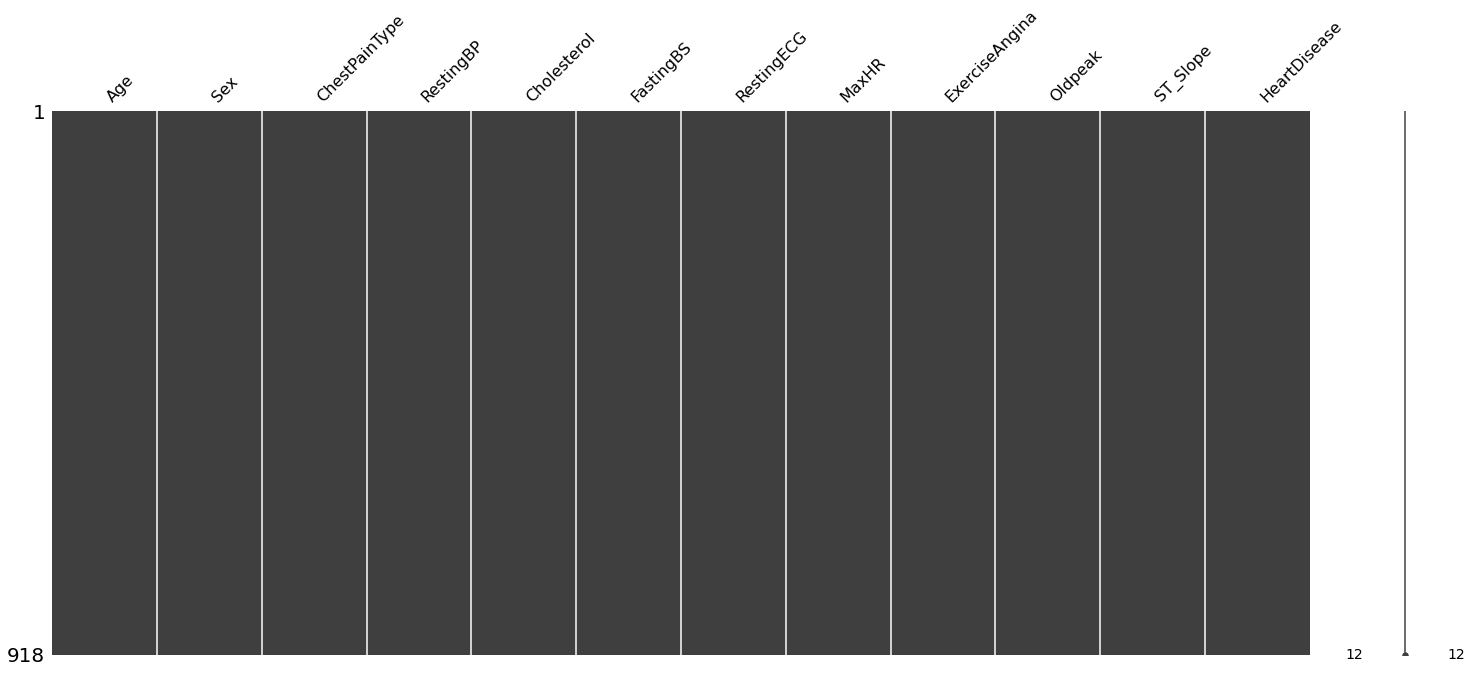

In [7]:
import missingno as msno
msno.matrix(heart_df)

<span style="color:Blue"> Observation:
    
**OK. There is no missing values!**

# Checking the data type of features

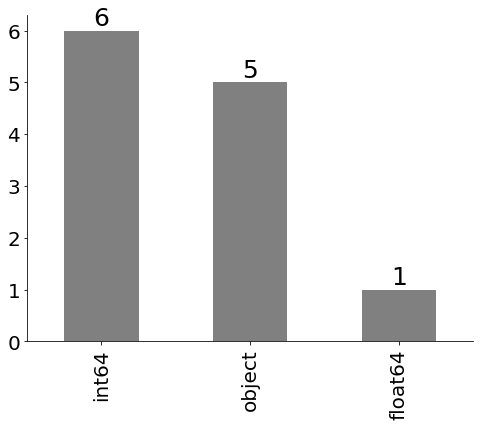

In [8]:
plt.figure(figsize = (8,6))
ax = heart_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 0.1, height, ha = 'center', size = 25)
sns.despine()

-------------------------------------------
# Checking Target Imbalance

In [9]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Heart Disease']
values = heart_df['HeartDisease'].value_counts()/heart_df['HeartDisease'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Heart Disease",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

<span style="color:Blue"> Observation:
    
**OK! Target is balanced!**

<hr style="border: solid 2px black;">

# Categorical Features

![](https://miro.medium.com/max/1400/1*wYbTRM0dgnRzutwZq63xCg.png)



Picture Credit: https://miro.medium.com

In [10]:
cat_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if
                    heart_df[cname].dtype == "object"]

# Select numerical columns
int_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if 
                heart_df[cname].dtype in ['int64']]
float_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if 
                heart_df[cname].dtype in ['float64']]

num_cols = int_cols + float_cols

------------------------------------
## Sex 

The person's sex (1 = male, 0 = female)

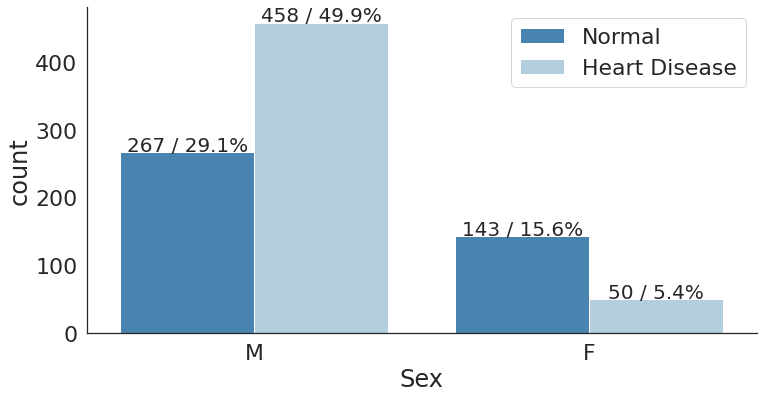

In [11]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='Sex',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* A man was diagnosed with a lot.
* Men were diagnosed with heart disease more than women. 

---------------------------------------------------
### ChestPainType ( Chest Pain Type )

![](https://o.quizlet.com/rwDb1FoclpuIIEjpRH317g.png)

Picture Credit: https://o.quizlet.com
The chest pain experienced 
* TA: typical angina 
* ATA: atypical angina 
* NAP: non-anginal pain
* ASY: asymptomatic

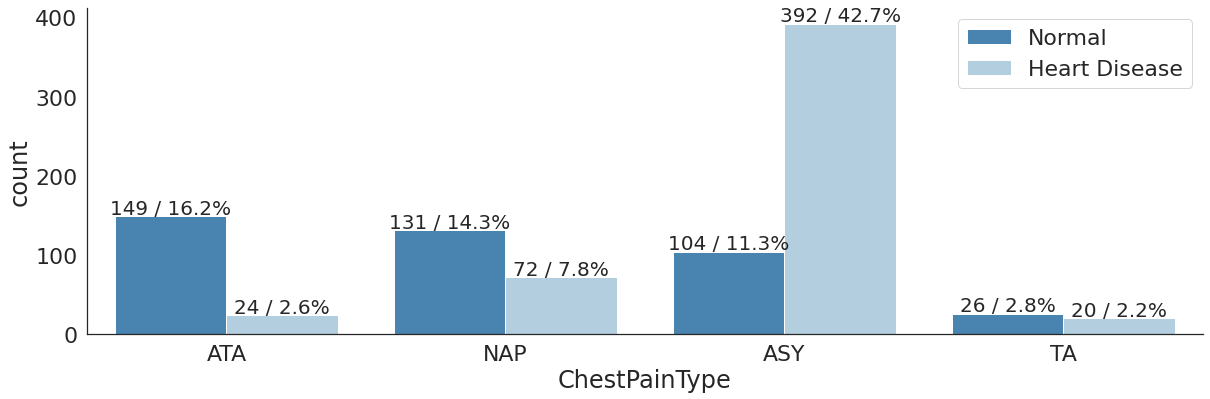

In [12]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(20,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='ChestPainType',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* Even asymptomatic patients are often diagnosed with heart disease!

-----------------------------------------------------------
## RestingECG ( resting electrocardiogram results )

![](https://www.assignmentpoint.com/wp-content/uploads/2015/10/electrocardiography.jpg)

Picture Credit: https://www.assignmentpoint.com


Ref: https://www.nhs.uk/conditions/electrocardiogram

Resting electrocardiographic measurement

* Normal: Normal, 
* ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
* LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria

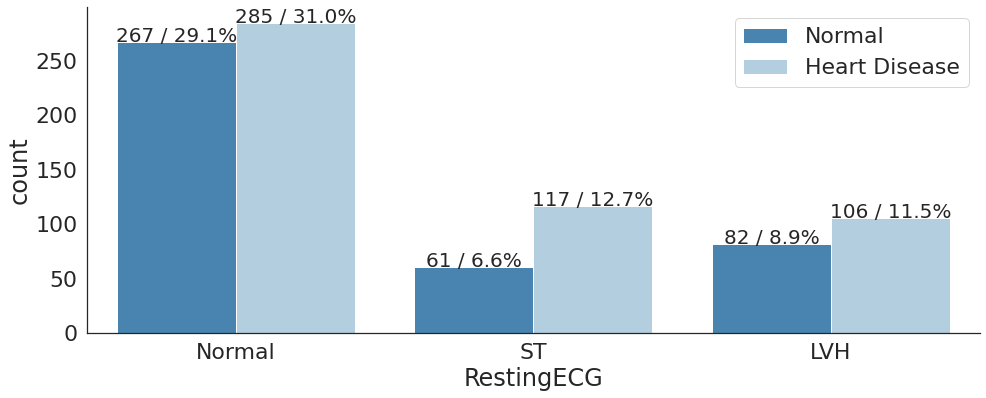

In [13]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(16,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='RestingECG',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 5, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

----------------------------------------------------------
## ExerciseAngina  (Exercise induced angina)



![](http://res.heraldm.com/content/image/2014/09/25/20140925001325_0.jpg)

Picture Credit: http://res.heraldm.com

Exercise-induced angina 
* Y: Yes 
* N: No

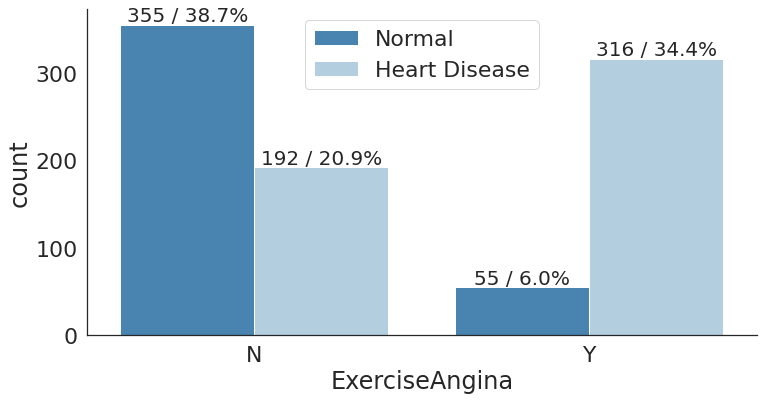

In [14]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='ExerciseAngina',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* Heart disease is often diagnosed when exercise-induced angina is present.

---------------------------------------------
## ST_Slope ( the slope of the peak exercise ST segment )

![](https://litfl.com/wp-content/uploads/2018/10/ST-segment-depression-upsloping-downsloping-horizontal.png)

Picture Credit: https://litfl.com/wp-content

The slope of the peak exercise ST segment 
* Up: upsloping
* Flat: flat
* Down: downsloping

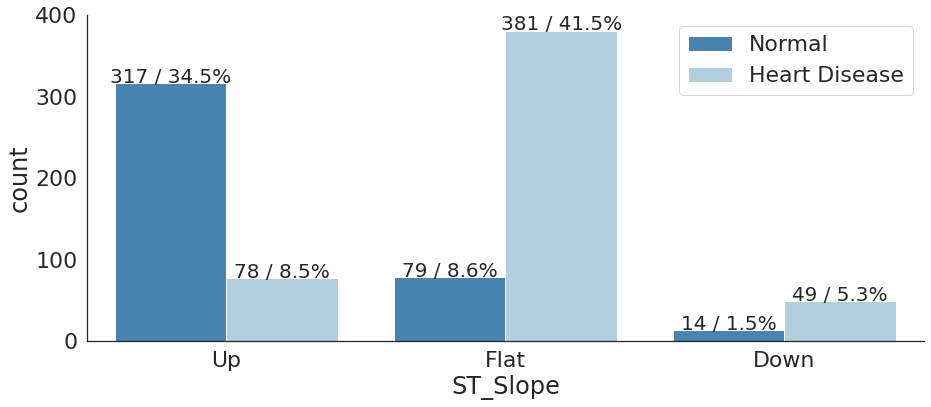

In [15]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(15,6))
sns.set(font_scale = 2)
plt.subplots_adjust(wspace=0.3)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='ST_Slope',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* When ST_Slope is Up, it is often judged as Normal.
* If ST_Slope is flat/down, it is often judged as heart disease.

----------------------
## FastingBS
fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

![](https://bizimages.withfloats.com/actual/5cf01dd2a5a2e6000120f19f.jpg)

Picture Credit: https://bizimages.withfloats.com


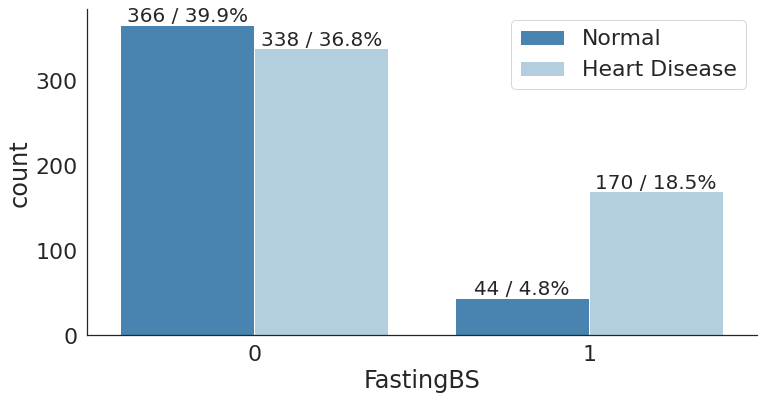

In [16]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='FastingBS',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* When ST_Slope is Up, it is often judged as Normal.
* If ST_Slope is flat/down, it is often judged as heart disease.

In [17]:
num_cols.remove("FastingBS")

<hr style="border: solid 2px black;">

# Numerical Features

![](https://static-assets.codecademy.com/Courses/Hypothesis-Testing/Intro_to_variable_types_4.png)

Picture Credit: https://t3.ftcdn.net

In [18]:
def display_stat(feature):
    mean = heart_df[feature].mean()
    std = heart_df[feature].std()
    skew = heart_df[feature].skew()
    kurtosis = heart_df[feature].kurtosis()
    print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))

----------------------------------------------------
## Age

In [19]:
plot_histgram('Age')
display_stat('Age')

mean: 53.5109, std: 9.4326, skew: -0.1959, kurtosis: -0.3861 


<span style="color:Blue"> Observation:
* The median of the age of people judged for heart disease is 57 years old, which is larger than the median value of normal people.

---------------------------------------------
## RestingBP ( resting blood pressure [mm Hg] )

![](https://health.clevelandclinic.org/wp-content/uploads/sites/3/2019/10/bloodPressurePreg-942572774-770x553.jpg)

Picture Credit: https://health.clevelandclinic.org

In [20]:
plot_histgram('RestingBP')
display_stat('RestingBP')

mean: 132.3965, std: 18.5142, skew: 0.1798, kurtosis: 3.2713 


<span style="color:Blue"> Observation:
    
In the figure above, there is a value of 0. If the blood pressure is 0, it is not actually possible, so it is likely to be judged as an outlier.

## Handling outlier

Let's change the outlier to the median value.

In [21]:
heart_df['RestingBP'].replace(0, heart_df['RestingBP'].median(),inplace=True)

In [22]:
plot_histgram('RestingBP')
display_stat('RestingBP')

mean: 132.5381, std: 17.9901, skew: 0.6080, kurtosis: 0.7962 


<span style="color:Blue"> Observation:
    
Outliers have been removed, and skewness and kurtosis are also stable.

-------------------------------------------------------
## Cholesterol ( serum cholesterol [mm/dl] )

![](https://victorchang-cdn.imgix.net/assets/src/uploads/How-is-High-Cholesterol-Measured-Heart-Health-Check.png)

Picture Credit: https://victorchang-cdn.imgix.net

> Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level.
> 
> “Normal ranges” are less important than your overall cardiovascular risk. Like HDL and LDL cholesterol levels, your total blood cholesterol level should be considered in context with your other known risk factors.
> 
> Your doctor can recommend treatment approaches accordingly.

Ref: https://www.heart.org/en/health-topics

In [23]:
plot_histgram('Cholesterol')
display_stat('Cholesterol')

mean: 198.7996, std: 109.3841, skew: -0.6101, kurtosis: 0.1182 


<span style="color:Blue"> Observation:
    
In the figure above, there are values that are 0. If serum cholesterol is 0, it is not possible in practice, so it is likely to be judged as an outlier.

## Handling outlier

Let's change the outlier to the median value.

In [24]:
heart_df['Cholesterol'].replace(0, heart_df['Cholesterol'].median(),inplace=True)

In [25]:
plot_histgram('Cholesterol')
display_stat('Cholesterol')

mean: 240.5817, std: 53.9830, skew: 1.5374, kurtosis: 6.2441 


<span style="color:Blue"> Observation:
    
Outliers have been removed, and skewness and kurtosis are also stable.

---------------------------------------------------
## MaxHR ( maximum heart rate achieved [Numeric value between 60 and 202] )

![](https://i0.wp.com/www.healthyperformance.co.uk/wp-content/uploads/2020/02/max-heart-rate.png)

Picture Credit: https://i0.wp.com

In [26]:
plot_histgram('MaxHR')
display_stat('MaxHR')

mean: 136.8094, std: 25.4603, skew: -0.1444, kurtosis: -0.4482 


<span style="color:Blue"> Observation:
    
Outliers are not observed, and the distribution of values seems reasonable.

---------------------------------------------
## Oldpeak ( oldpeak = ST [Numeric value measured in depression] )

ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)

![](https://www.researchgate.net/profile/Chandrasekhar-Nataraj/publication/224830806/figure/fig1/AS:302793928790021@1449203106175/The-components-of-the-ECG-signal.png)

Picture Credit: https://www.researchgate.net

In [27]:
plot_histgram('Oldpeak')
display_stat('Oldpeak')

mean: 0.8874, std: 1.0666, skew: 1.0229, kurtosis: 1.2031 


<span style="color:Blue"> Observation:
    
Without domain knowledge, it is difficult to determine the normal range of the value. If anyone knows the normal range for this value, please let me know.

------------------------------------------------------------------
# Encoding

In [28]:
heart_df = pd.get_dummies(heart_df,drop_first=True)

<hr style="border: solid 3px blue;">

# Checking Feature Importance

**Here we check feature importance in various ways.**

Knowing which features are important when judging heart disease from different features will help you make a decision. It will also be very helpful when explaining to people who have been diagnosed.

Text(0.5, 1.0, 'Correlation Plot')

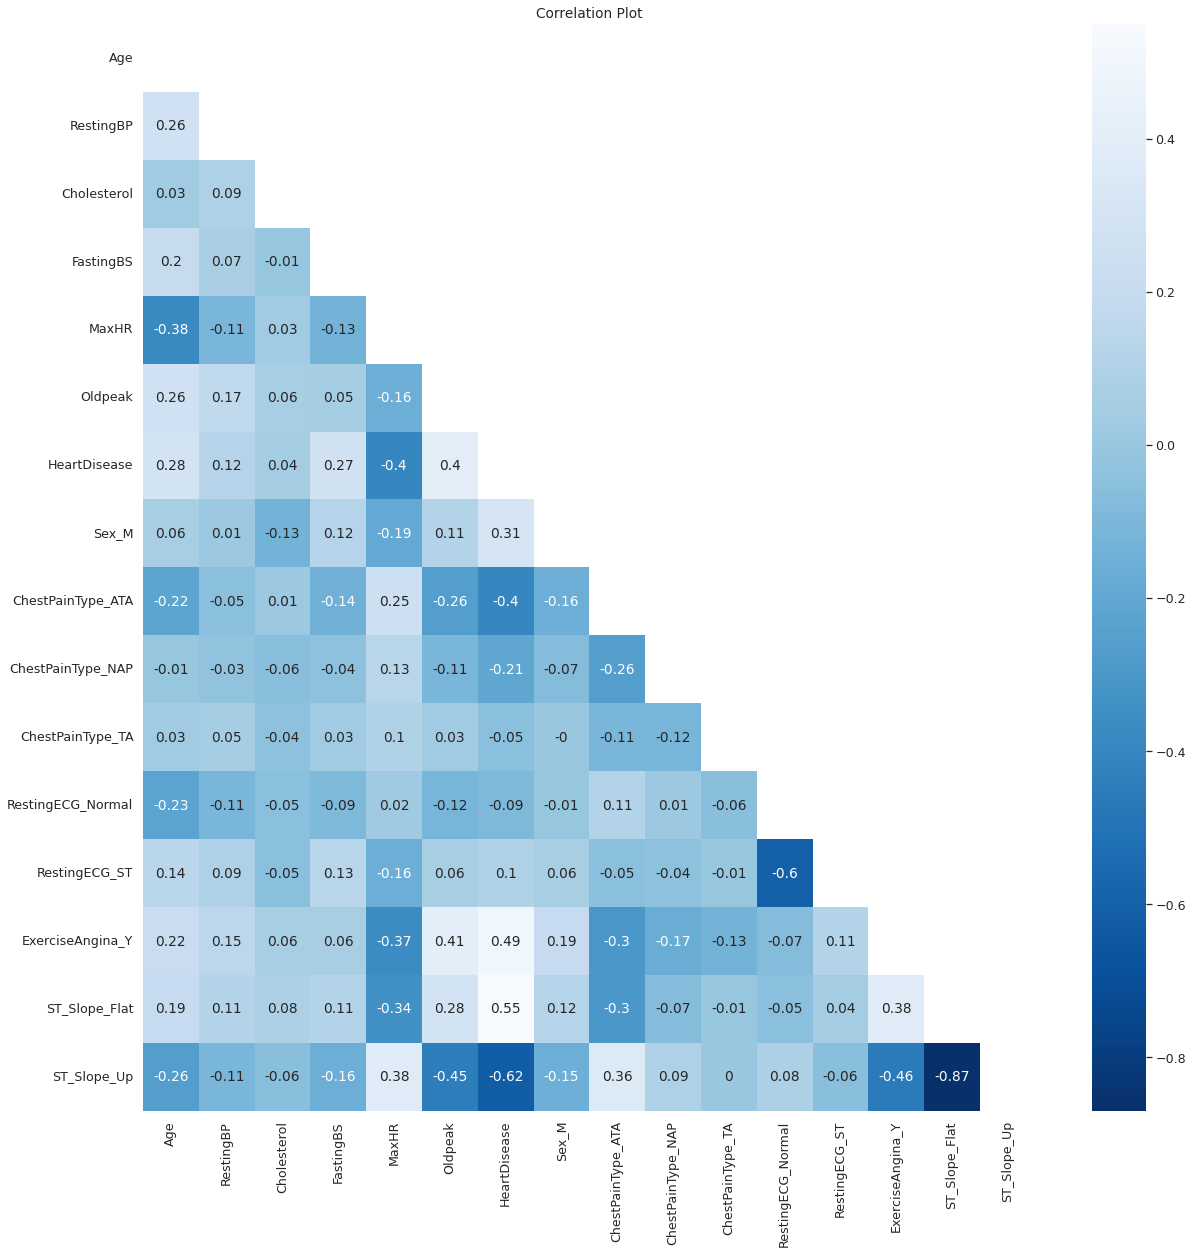

In [29]:
corr=heart_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(20, 20))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='Blues_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

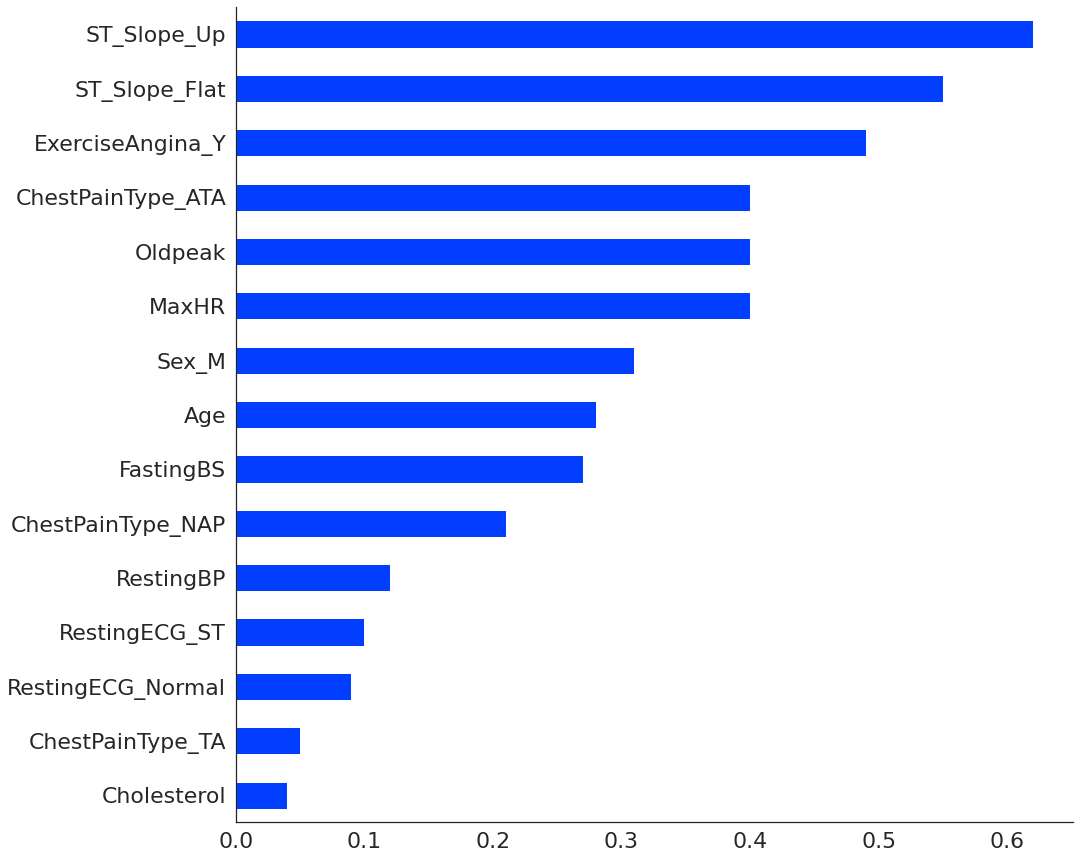

In [30]:
sns.set(font_scale=2)
plt.figure(figsize=(15, 15))
sns.set_style("white")
sns.set_palette("bright")
abs(corr['HeartDisease']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
sns.despine()

<span style="color:Blue"> Observation:
* The correlation between heart disease and ST_Slope_Up and ST_Slope_Flat is high.

------------------------------------------------------------------------------
## Feature importance with partial dependence

> Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest

Ref: https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence

In [31]:
heart_df_copy = heart_df.copy()
X_train = heart_df_copy.drop('HeartDisease',axis=1)
y_train = heart_df_copy.pop('HeartDisease')

In [32]:
all_cols = [cname for cname in X_train.columns]

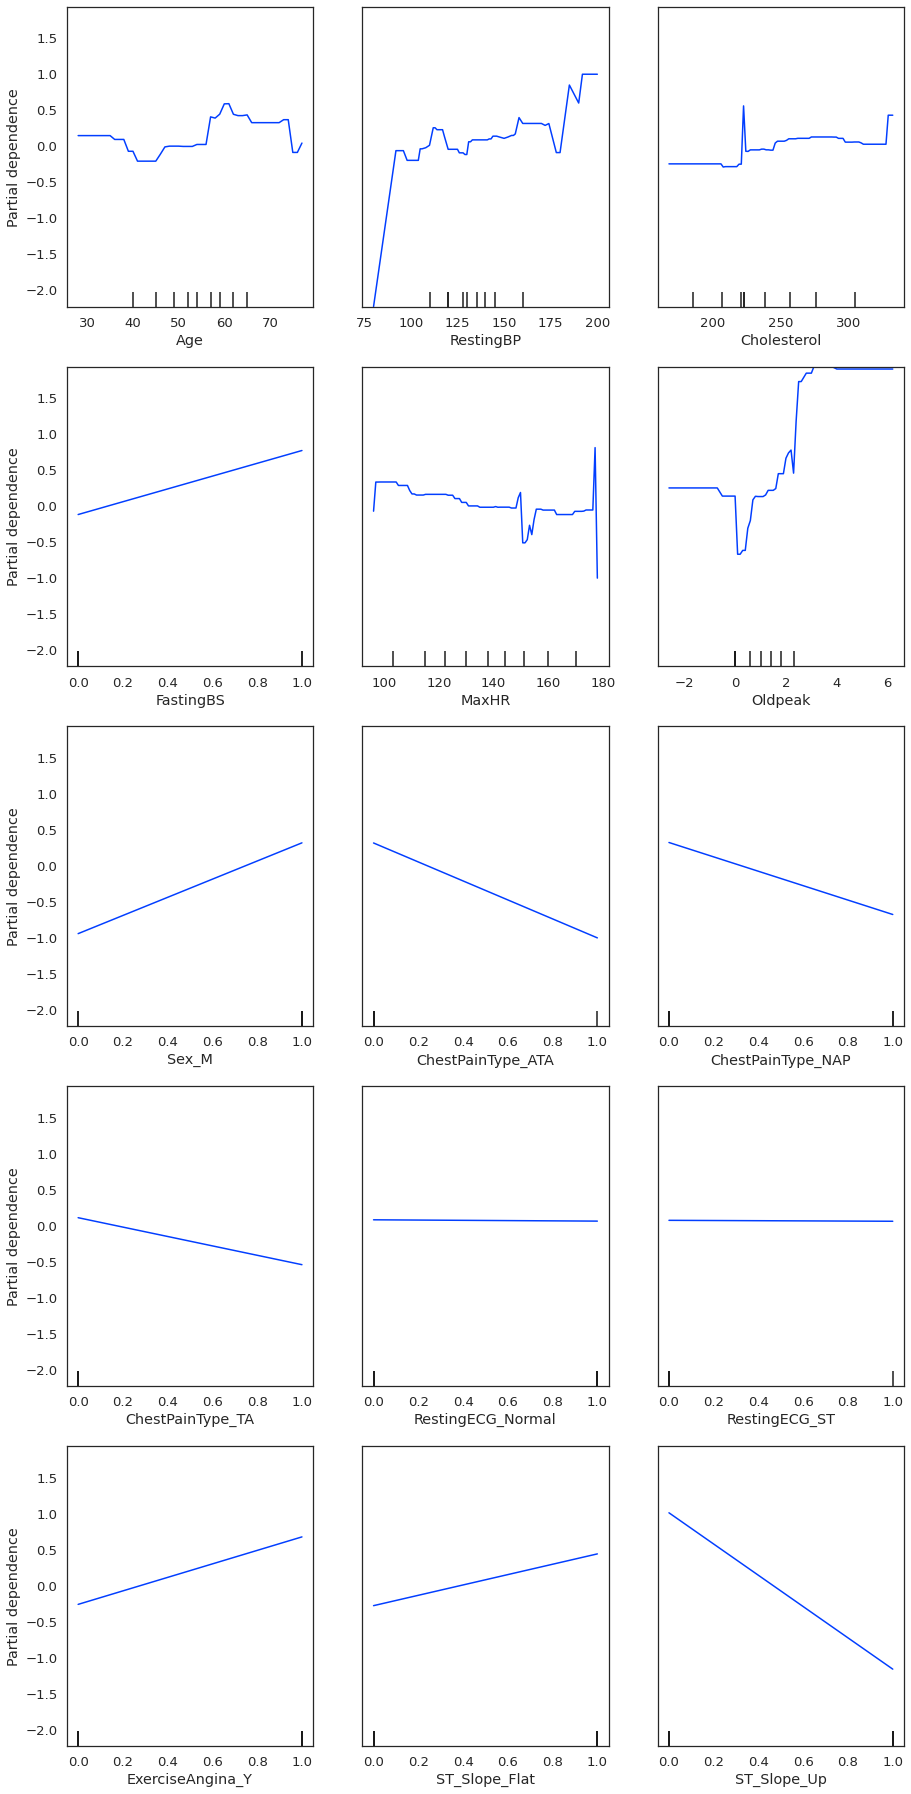

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence

clf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("bright")
fig,ax = plt.subplots(figsize=(15,32))
plot_partial_dependence(clf, X_train, all_cols, ax=ax)

<span style="color:Blue"> Observation:
* As the value of the ST_Slope_Up feature increases, the case of heart disease becomes smaller.
* If the value of OldPeak is greater than 0, the judgment of heart disease increases. And, the slope is large.

------------------------------------------------
## Feature importance based on mean decrease in impurity

After calculating the sum of the decrease of impurity at the point of splitting based on the corresponding feature in each tree, this
Mean decrease Gini is the average of all tree values. This value will increase as the feature becomes important for the model to classify well.

In [34]:
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)

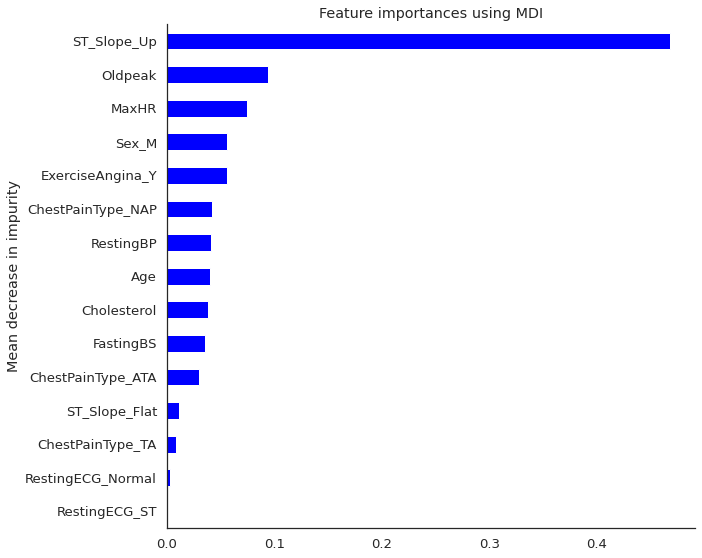

In [35]:
forest_importances = pd.Series(importances, index=all_cols)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,8))
forest_importances.sort_values().plot.barh(yerr=std, ax=ax, color='blue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---------------------------------------------------------------------------
# Feature importance based on feature permutation

> The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

Ref: https://scikit-learn.org/stable

In [36]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=all_cols)

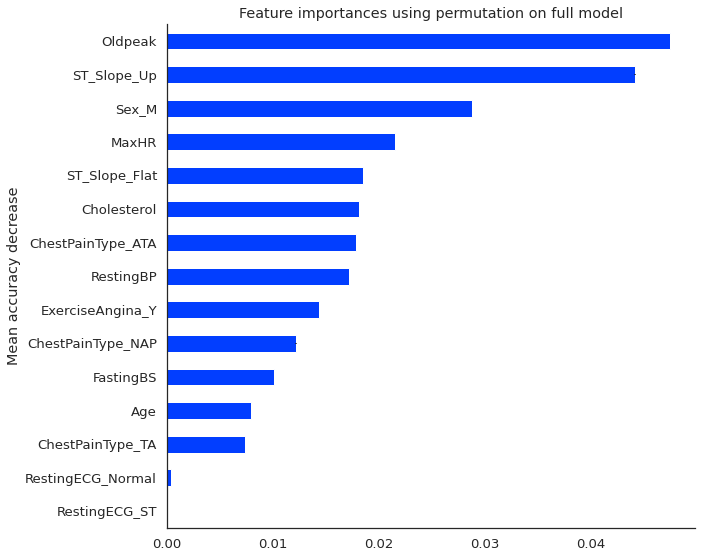

In [37]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,8))
forest_importances.sort_values().plot.barh(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

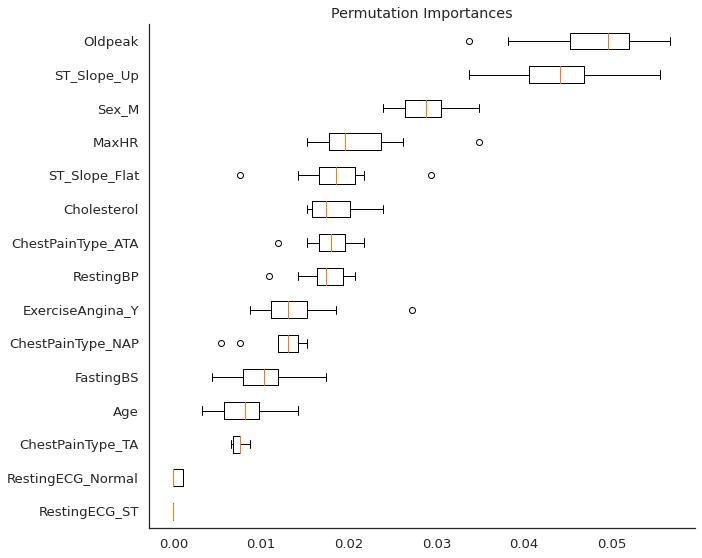

In [38]:
sorted_idx = result.importances_mean.argsort()
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<hr style="border: solid 3px blue;">

# Visualizing Training Dataset after Dimension Reduction
The preprocessed training dataset is 15 dimensions. After reducing the dimensions to 2D and 3D, let's check the distribution for each price.

## Plotting after dimensionality reduction to 2D

<AxesSubplot:>

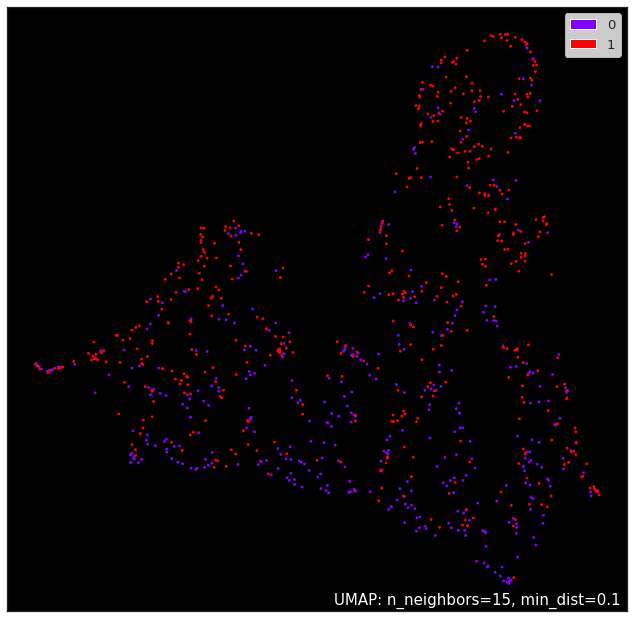

In [39]:
import umap
import umap.plot
mapper = umap.UMAP().fit(X_train)
umap.plot.points(mapper, labels=y_train, theme='fire')

In [40]:
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='HeartDisease')
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='HeartDisease', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<hr style="border: solid 3px blue;">

# Modeling

![](https://ak.picdn.net/shutterstock/videos/3294029/thumb/1.jpg)

Picture Credit: https://ak.picdn.net/shutterstock

> Supervised learning algorithms perform the task of searching through a hypothesis space to find a suitable hypothesis that will make good predictions with a particular problem.Even if the hypothesis space contains hypotheses that are very well-suited for a particular problem, it may be very difficult to find a good one. Ensembles combine multiple hypotheses to form a (hopefully) better hypothesis. The term ensemble is usually reserved for methods that generate multiple hypotheses using the same base learner. The broader term of multiple classifier systems also covers hybridization of hypotheses that are not induced by the same base learner.

Ref: https://en.wikipedia.org/wiki/Ensemble_learning

For the final diagnosis of a certain patient, you can make a judgment by collecting opinions of several doctors. In this case, more accurate results can be obtained than the results judged by a single, outstanding doctor. It can be called the power of collective intelligence.

In [41]:
from pycaret.classification import *

-----------------------------------------------------------
# Setting Up

> This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function. It takes two mandatory parameters: data and target. All the other parameters are optional.


Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [42]:
setup(data = heart_df, 
             target = 'HeartDisease',
             preprocess = False,
             numeric_features = all_cols,
             silent = True)

,Description,Value
0,session_id,3100
1,Target,HeartDisease
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(918, 16)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,0
8,Transformed Train Set,"(642, 15)"
9,Transformed Test Set,"(276, 15)"


(None,
 [],
 'box-cox',
 'lightgbm',
 False,
 False,
 [('Setup Config',
                 Description             Value
   0              session_id              3100
   1                  Target      HeartDisease
   2             Target Type            Binary
   3           Label Encoded              None
   4           Original Data         (918, 16)
   5          Missing Values             False
   6        Numeric Features                15
   7    Categorical Features                 0
   8   Transformed Train Set         (642, 15)
   9    Transformed Test Set         (276, 15)
   10     Shuffle Train-Test              True
   11    Stratify Train-Test             False
   12         Fold Generator   StratifiedKFold
   13            Fold Number                10
   14               CPU Jobs                -1
   15                Use GPU             False
   16         Log Experiment             False
   17        Experiment Name  clf-default-name
   18                    USI       

--------------------------------------------------
## Comparing Models

> This function trains and evaluates performance of all estimators available in the model library using cross validation. The output of this function is a score grid with average cross validated scores. 

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [43]:
top5 = compare_models(sort='Recall',n_select = 5,exclude=['ridge','svm','dummy','knn','dt','qda','ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8660,0.9302,0.8917,0.8693,0.8788,0.7290,0.7325,1.3960
xgboost,Extreme Gradient Boosting,0.8615,0.9177,0.8892,0.8627,0.8744,0.7201,0.7236,17.1780
lightgbm,Light Gradient Boosting Machine,0.8599,0.9159,0.8890,0.8620,0.8738,0.7163,0.7198,0.1210
et,Extra Trees Classifier,0.8520,0.9253,0.8860,0.8526,0.8676,0.6999,0.7032,0.2780
rf,Random Forest Classifier,0.8458,0.9209,0.8775,0.8497,0.8614,0.6875,0.6922,0.3120
gbc,Gradient Boosting Classifier,0.8583,0.9318,0.8775,0.8680,0.8710,0.7137,0.7174,0.0680
lda,Linear Discriminant Analysis,0.8474,0.9180,0.8718,0.8557,0.8619,0.6912,0.6949,0.0100
lr,Logistic Regression,0.8489,0.9147,0.8690,0.8603,0.8624,0.6948,0.6990,0.5970
nb,Naive Bayes,0.8444,0.9168,0.8491,0.8662,0.8550,0.6869,0.6919,0.0090


-----------------------------------------
## Creating Models

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [44]:
xgboost = create_model('xgboost')
rf = create_model('rf')
lightgbm = create_model('lightgbm')
gbc = create_model('gbc')
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8308,0.9010,0.8571,0.8333,0.8451,0.6587,0.6590
1,0.9077,0.9358,0.9167,0.9167,0.9167,0.8132,0.8132
2,0.8906,0.9350,0.9143,0.8889,0.9014,0.7787,0.7790
3,0.8750,0.9379,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8594,0.9094,0.9143,0.8421,0.8767,0.7137,0.7170
5,0.9062,0.9596,0.9429,0.8919,0.9167,0.8097,0.8113
6,0.8438,0.9379,0.8857,0.8378,0.8611,0.6829,0.6842
7,0.8906,0.9498,0.8571,0.9375,0.8955,0.7812,0.7847
8,0.8281,0.9310,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8281,0.9044,0.8857,0.8158,0.8493,0.6501,0.6531


---------------------------------------------
## Interpreting Models

![](https://blog.datascienceheroes.com/content/images/2019/03/simpsons.gif)

Picture Credit: https://blog.datascienceheroes.com

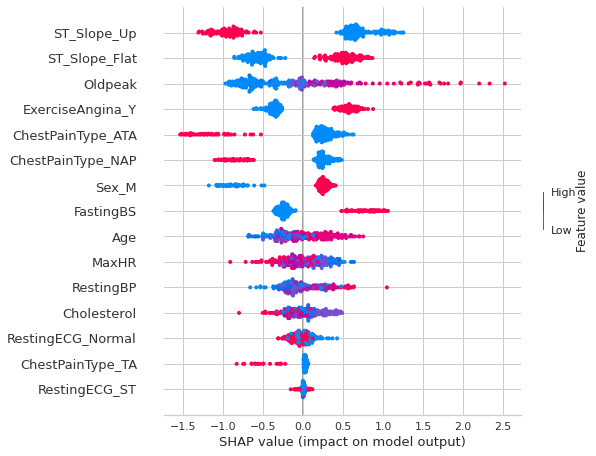

In [45]:
interpret_model(catboost)

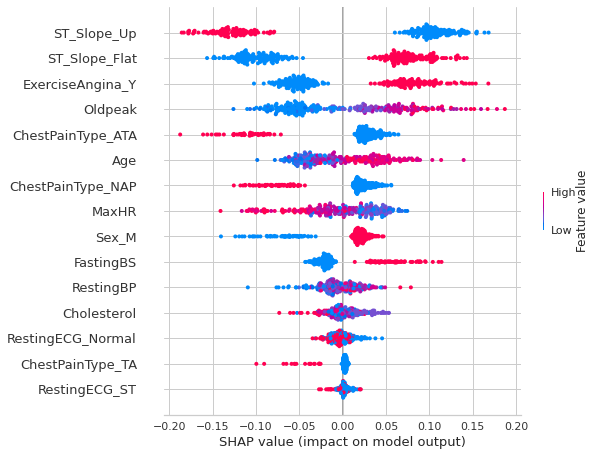

In [46]:
interpret_model(rf)

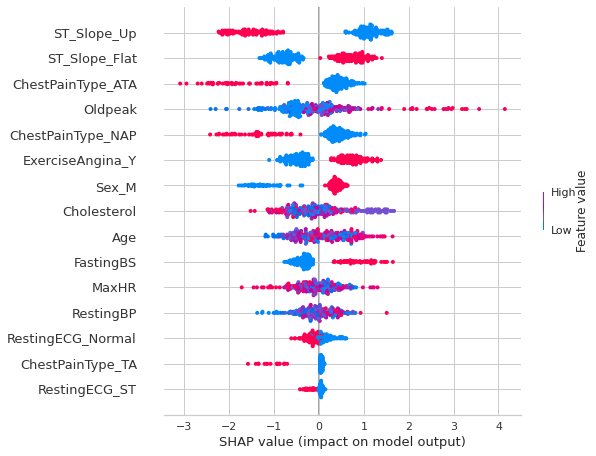

In [47]:
interpret_model(lightgbm)

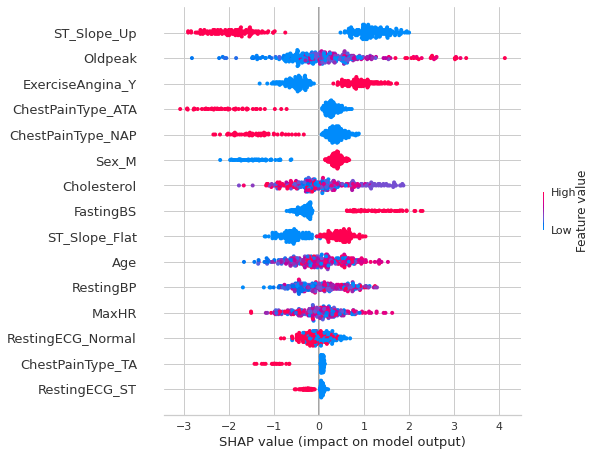

In [48]:
interpret_model(xgboost)

<span style="color:Blue"> Observation:
* ST_Slope_Up feature is used as the most important feature in all models.
* Oldpeak feature is used as an important feature in most models.
* RestingECG_ST features have the lowest importance in all models.   

Let's compare the feature importance of the above two models. A comparison was made with SHAP values, and the feature importance of each model is slightly different.
The diversity of each model seems to be stable and improve performance while compensating for each other's weaknesses.

----------------------------------------------
## Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [49]:
xgboost = create_model('xgboost')
rf = create_model('rf')
lightgbm = create_model('lightgbm')
gbc = create_model('gbc')
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8308,0.9010,0.8571,0.8333,0.8451,0.6587,0.6590
1,0.9077,0.9358,0.9167,0.9167,0.9167,0.8132,0.8132
2,0.8906,0.9350,0.9143,0.8889,0.9014,0.7787,0.7790
3,0.8750,0.9379,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8594,0.9094,0.9143,0.8421,0.8767,0.7137,0.7170
5,0.9062,0.9596,0.9429,0.8919,0.9167,0.8097,0.8113
6,0.8438,0.9379,0.8857,0.8378,0.8611,0.6829,0.6842
7,0.8906,0.9498,0.8571,0.9375,0.8955,0.7812,0.7847
8,0.8281,0.9310,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8281,0.9044,0.8857,0.8158,0.8493,0.6501,0.6531


In [50]:
tuned_xgboost = tune_model(xgboost, optimize = 'Recall')
tuned_rf = tune_model(rf, optimize = 'Recall')
tuned_lightgbm = tune_model(lightgbm, optimize = 'Recall')
tuned_gbc = tune_model(gbc, optimize = 'Recall')
tuned_catboost = tune_model(catboost, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8462,0.9067,0.8571,0.8571,0.8571,0.6905,0.6905
1,0.8769,0.9339,0.8611,0.9118,0.8857,0.7526,0.7541
2,0.8750,0.9300,0.9143,0.8649,0.8889,0.7463,0.7478
3,0.8906,0.9586,0.9714,0.8500,0.9067,0.7760,0.7861
4,0.8594,0.9192,0.9429,0.8250,0.8800,0.7120,0.7213
5,0.9219,0.9754,0.9714,0.8947,0.9315,0.8410,0.8448
6,0.9062,0.9547,0.9429,0.8919,0.9167,0.8097,0.8113
7,0.8750,0.9291,0.8286,0.9355,0.8788,0.7507,0.7566
8,0.8281,0.9379,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8750,0.9123,0.9429,0.8462,0.8919,0.7448,0.7509


----------------------------------------
## Stacking 

![](https://miro.medium.com/max/1000/1*CoauXirckomVXxw2Id2w_Q.jpeg)

Picture Credit: https://miro.medium.com

In [51]:
stack_model = stack_models(estimator_list = [xgboost,rf,lightgbm,gbc,catboost], meta_model = catboost,optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8462,0.9019,0.8857,0.8378,0.8611,0.6890,0.6903
1,0.8769,0.9310,0.8889,0.8889,0.8889,0.7510,0.7510
2,0.8438,0.9389,0.9429,0.8049,0.8684,0.6790,0.6920
3,0.8750,0.9340,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8594,0.9182,0.9143,0.8421,0.8767,0.7137,0.7170
5,0.9375,0.9606,0.9714,0.9189,0.9444,0.8731,0.8749
6,0.8750,0.9330,0.9429,0.8462,0.8919,0.7448,0.7509
7,0.8750,0.9567,0.8286,0.9355,0.8788,0.7507,0.7566
8,0.8281,0.9330,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8906,0.9133,0.9714,0.8500,0.9067,0.7760,0.7861


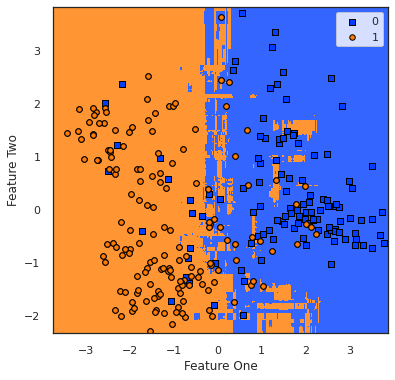

In [52]:
sns.set(font_scale=1)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(6, 6))
plot_model(stack_model, plot='boundary')

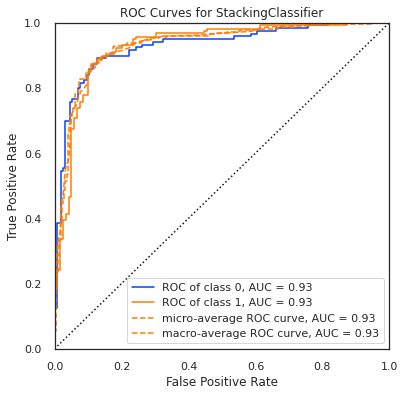

In [53]:
sns.set(font_scale=1)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(6, 6))
plot_model(stack_model, plot = 'auc')

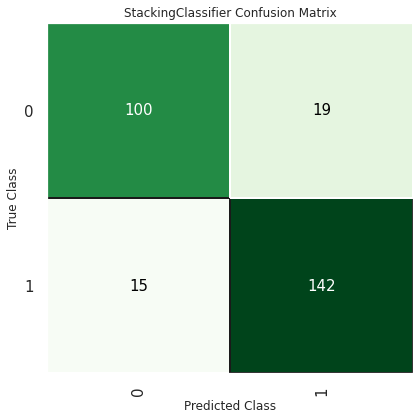

In [54]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plot_model(stack_model, plot='confusion_matrix')

--------------------------------------------------
## Soft Voting

![](https://miro.medium.com/max/806/1*bliKQZGPccS7ho9Zo6uC7A.jpeg)

Picture Credit: https://miro.medium.com

> This function trains a Soft Voting classifier for select models passed in the estimator_list param. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [55]:
blend_soft = blend_models(estimator_list = [xgboost,rf,lightgbm,gbc,catboost], optimize = 'Recall',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8154,0.8971,0.8286,0.8286,0.8286,0.6286,0.6286
1,0.8615,0.9291,0.8611,0.8857,0.8732,0.7208,0.7211
2,0.9062,0.9527,0.9429,0.8919,0.9167,0.8097,0.8113
3,0.8750,0.9320,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8438,0.9143,0.9143,0.8205,0.8649,0.6810,0.6866
5,0.9219,0.9606,0.9429,0.9167,0.9296,0.8419,0.8423
6,0.8750,0.9438,0.9143,0.8649,0.8889,0.7463,0.7478
7,0.8906,0.9547,0.8571,0.9375,0.8955,0.7812,0.7847
8,0.8281,0.9192,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8438,0.8956,0.9143,0.8205,0.8649,0.6810,0.6866


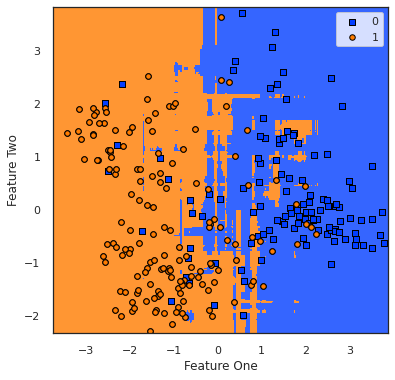

In [56]:
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(6, 6))
plot_model(blend_soft, plot='boundary')

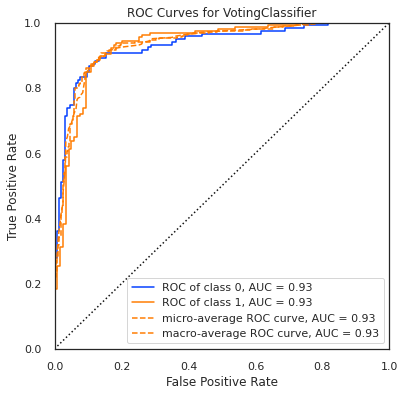

In [57]:
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(6, 6))
plot_model(blend_soft, plot = 'auc')

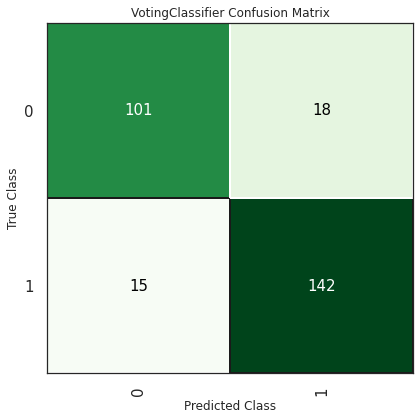

In [58]:
plt.figure(figsize=(6, 6))
plot_model(blend_soft, plot='confusion_matrix')

--------------------------------------------------
## Hard Voting

![](https://miro.medium.com/max/428/1*XnZwlg7Th3nga25sSlanJQ.jpeg)

Picture Credit: https://vitalflux.com


> This function trains a **Majority Rule classifier** for select models passed in the estimator_list param. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [59]:
blend_hard = blend_models(estimator_list = [xgboost,rf,lightgbm,gbc,catboost], optimize = 'Recall',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8308,0.0000,0.8571,0.8333,0.8451,0.6587,0.6590
1,0.8615,0.0000,0.8611,0.8857,0.8732,0.7208,0.7211
2,0.8750,0.0000,0.9143,0.8649,0.8889,0.7463,0.7478
3,0.8750,0.0000,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8438,0.0000,0.8857,0.8378,0.8611,0.6829,0.6842
5,0.9219,0.0000,0.9429,0.9167,0.9296,0.8419,0.8423
6,0.8906,0.0000,0.9143,0.8889,0.9014,0.7787,0.7790
7,0.8906,0.0000,0.8571,0.9375,0.8955,0.7812,0.7847
8,0.8281,0.0000,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8281,0.0000,0.9143,0.8000,0.8533,0.6480,0.6565


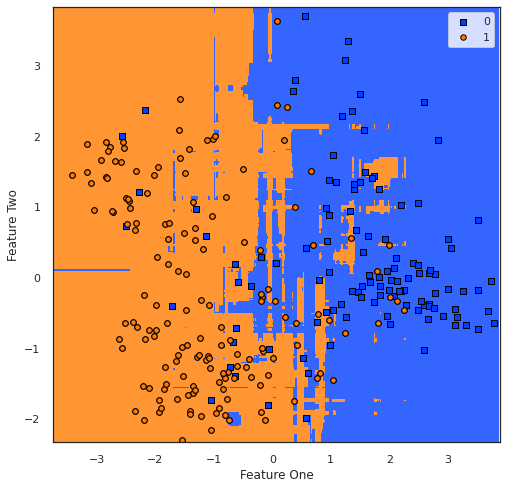

In [60]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

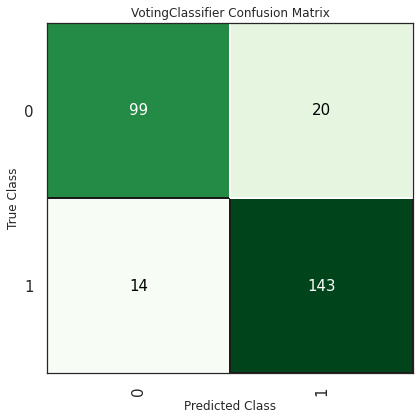

In [61]:
plt.figure(figsize=(6, 6))
plot_model(blend_hard, plot='confusion_matrix')

------------------------------------------
## Calibrating the final model
> This function calibrates the probability of a given estimator using isotonic or logistic regression.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

When judging the performance of the above three ensemble models by recall, the soft voting model has the best performance. Therefore, the soft voting model is selected as the final model and calibration is performed.

In [62]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8308,0.8990,0.8571,0.8333,0.8451,0.6587,0.6590
1,0.8769,0.9310,0.8611,0.9118,0.8857,0.7526,0.7541
2,0.8906,0.9389,0.9429,0.8684,0.9041,0.7773,0.7809
3,0.8750,0.9330,0.9714,0.8293,0.8947,0.7432,0.7574
4,0.8438,0.9113,0.9143,0.8205,0.8649,0.6810,0.6866
5,0.9375,0.9626,0.9714,0.9189,0.9444,0.8731,0.8749
6,0.8750,0.9448,0.9143,0.8649,0.8889,0.7463,0.7478
7,0.8906,0.9458,0.8571,0.9375,0.8955,0.7812,0.7847
8,0.8281,0.9271,0.7714,0.9000,0.8308,0.6583,0.6663
9,0.8438,0.8956,0.9143,0.8205,0.8649,0.6810,0.6866


<span style="color:Blue"> Observation:
* The recall of the model completed until calibration is over 90%.

----------------------------------------------------------------------------
## Finalizing the last model
> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [63]:
final_model = finalize_model(cali_model)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

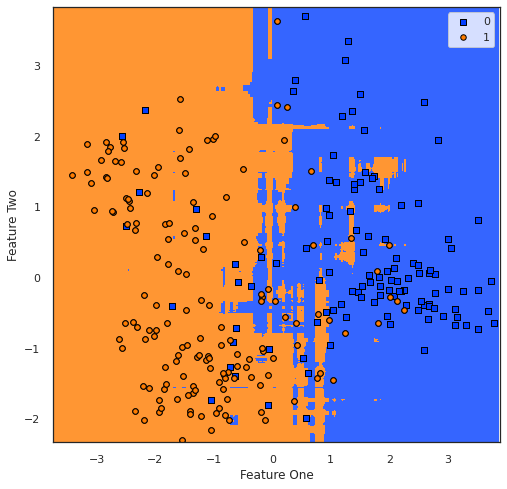

In [64]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

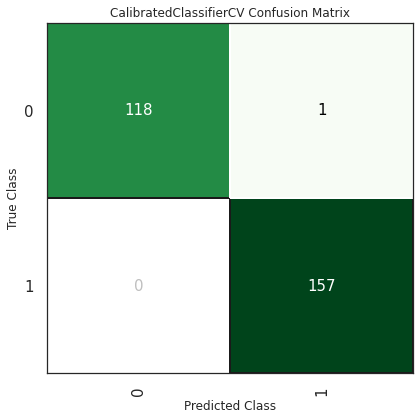

In [65]:
plt.figure(figsize=(6, 6))
plot_model(final_model, plot='confusion_matrix')

<hr style="border: solid 3px blue;">